<div align="right">
Massimo Nocentini<br>
<br>September 8, 2016: synchronous fetching, drawing
</div>
<br>
<div align="center">
<b>Abstract</b><br>
This document describes our effort to perform mining techniques on the [OEIS][oeis].
</div>

[oeis]:http://oeis.org

**Imports**

The following cell import the function `oeis_search` in order to query the *Online Encyclopedia of Integer Sequences* and render search results directly in the current notebook; for a detailed tutorial, see http://nbviewer.jupyter.org/github/massimo-nocentini/competitive-programming/blob/master/tutorials/oeis-interaction.ipynb?flush_cache=true

In [1]:
from oeis import oeis_search

Follows `import`s required by this document.

In [2]:
from requests import get
import re
from itertools import count
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

## `asyncio` sandbox

The following imports are about `asyncio`:

In [3]:
import asyncio

### Simple example using `event_loop`

In [11]:

def hello_world(loop):
    print('Hello World')
    loop.stop()

loop = asyncio.get_event_loop()

# Schedule a call to hello_world()
loop.call_soon(hello_world, loop)

# Blocking call interrupted by loop.stop()
loop.run_forever()
print("before close")
loop.close()
print("after close")

RuntimeError: Event loop is closed

# Sandbox

In [ ]:

async def download(url, parts):
    async def get_partial_content(u, i, start, end):
        print(i, start, end)
        async with aiohttp.get(
                u, headers={"Range": "bytes={}-{}".format(start, end - 1 if end else "")}) as _resp:
            return i, await _resp.read()

    async with aiohttp.head(url) as resp:
        size = int(resp.headers["Content-Length"])

    ranges = list(range(0, size, size // parts))

    res, _ = await asyncio.wait(
        [get_partial_content(url, i, start, end) for i, (start, end) in
         enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

    sorted_result = sorted(task.result() for task in res)
    return b"".join(data for _, data in sorted_result)


if __name__ == '__main__':
    image_url = "http://files.vladstudio.com/joy/where_tahrs_live/wall/vladstudio_where_tahrs_live_2880x1800_signed.jpg"
    loop = asyncio.get_event_loop()
    bs = loop.run_until_complete(download(image_url, 16))

    with open("test_para_async.jpeg", "wb") as fi:
        fi.write(bs)

### Asynchronous version

In [28]:
async def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    async def fetch(seq_id):
        print("fetching sequence {}".format(seq_id))
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        return doc['results'].pop()

    def cross_references(xref):
        regex = re.compile('(?P<id>A\d{6,6})')
        return {int(r[1:]) for references in xref for r in regex.findall(references)}

    def not_seen_so_far(ref_seq_id):
            return ref_seq_id not in sink
    
    async def recursion(sequences, step):
        
        
            
        #res, _ = await asyncio.wait(
        #[get_partial_content(url, i, start, end) for i, (start, end) in
        # enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

        #sorted_result = sorted(task.result() for task in res)
        #return b"".join(data for _, data in sorted_result)
            
        if step > depth: return sink

        print("\nFetching sequences:\n{} ".format(sequences))
        
        res, _ = await asyncio.wait([fetch(ref_seq_id)
                                     for i, ref_seq_id in zip(count(), sequences)
                                     #if i < 5 # to delete when we arrive at a working prototype
                                    ])
        
        cross_sequences = set()
        
        for task in res: 
            
            result = task.result()
            sink.update({seq_id: result}) # since `recursion` is called if `seq_id` hasn't been fetched

            # preparing for recursion
            result['xref_as_set'] = cross_references(result['xref']) if 'xref' in result else set()
            cross_sequences |= result['xref_as_set']
            
        return await recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    return await recursion({seq_id}, step=0)
    

In [27]:
loop = asyncio.get_event_loop()
bs = loop.run_until_complete(oeis_graph(seq_id=45, depth=3))


NameError: name 'asyncio' is not defined

### Threading version

In [39]:
import queue
import threading
from multiprocessing.dummy import Pool as ThreadPool

def oeis_graph(seq_id, depth=2, workers=20):
        
    sink = {}
    
    def fetch(seq_id):
        
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        
        print("fetched sequence {}".format(seq_id))
        
        try:
            doc = doc_result.json()
            return doc['results'].pop()
        except Exception as e:
            print(e)
            return {}
        

    def cross_references(xref):
        regex = re.compile('(?P<id>A\d{6,6})')
        return {int(r[1:]) for references in xref for r in regex.findall(references)}#[:10]}

    def not_seen_so_far(ref_seq_id):
        return ref_seq_id not in sink
    
    def recursion(sequences, step):
        
        
            
        #res, _ = await asyncio.wait(
        #[get_partial_content(url, i, start, end) for i, (start, end) in
        # enumerate(itertools.zip_longest(ranges, ranges[1:], fillvalue=""))])

        #sorted_result = sorted(task.result() for task in res)
        #return b"".join(data for _, data in sorted_result)
            
        if step >= depth: return

        print("\nFetching sequences:\n{} ".format(sequences))

        pool = ThreadPool(workers) # Make the Pool of workers

        
        # Open the urls in their own threads
        # and return the results
        results = pool.map(fetch, sequences)

        print("message `pool.map` sent")
        
        #close the pool and wait for the work to finish
        pool.close()
        pool.join()

        print("pool closed and joint")
        
        cross_sequences = set()
        
        for result in results: 
            
            sink.update({int(result['number']): result}) # since `recursion` is called if `seq_id` hasn't been fetched

            # preparing for recursion
            result['xref_as_set'] = cross_references(result['xref']) if 'xref' in result else set()
            cross_sequences |= result['xref_as_set']
            
        recursion(set(filter(not_seen_so_far, cross_sequences)), step+1)
        
    recursion({seq_id}, step=0)
    
    return sink
    

In [41]:
graph = oeis_graph(seq_id=45, depth=3)


Fetching sequences:
{45} 
fetched sequence 45
message `pool.map` sent
pool closed and joint

Fetching sequences:
{114690, 36355, 94718, 383, 94216, 90888, 152063, 100492, 99731, 114197, 27926, 101399, 144152, 101400, 59929, 60441, 7317, 157725, 157726, 157727, 288, 157728, 157729, 32, 22307, 103323, 111006, 60455, 930, 37027, 104597, 94638, 38575, 3893, 162741, 1690, 6327, 109754, 71679, 957, 99390, 167616, 322, 3269, 262342, 71, 1611, 249548, 74829, 48887, 105809, 109906, 213, 20695, 91867, 20701, 39834, 738, 101220, 105317, 744, 30186, 228074, 108, 234357, 57078, 1911, 92921, 118654, 254719} 
fetched sequence 36355
fetched sequence 94216
fetched sequence 152063
fetched sequence 99731
fetched sequence 94718
fetched sequence 383
fetched sequence 114690
fetched sequence 114197
fetched sequence 101400
fetched sequence 27926
fetched sequence 59929
fetched sequence 157725
fetched sequence 157727
fetched sequence 144152
fetched sequence 60441
fetched sequence 157726
fetched sequence 101399

### An example using `ThreadPool`

In [7]:
%%time

import urllib.request
from multiprocessing.dummy import Pool as ThreadPool 

urls = [
  'http://www.python.org', 
  'http://www.python.org/about/',
  'http://www.onlamp.com/pub/a/python/2003/04/17/metaclasses.html',
  'http://www.python.org/doc/',
  'http://www.python.org/download/',
  'http://www.python.org/getit/',
  'http://www.python.org/community/',
  'https://wiki.python.org/moin/',
  ]

# Make the Pool of workers
pool = ThreadPool(4) 

# Open the urls in their own threads
# and return the results
results = pool.map(urllib.request.urlopen, urls)

#close the pool and wait for the work to finish 
pool.close() 
pool.join()


CPU times: user 210 ms, sys: 20 ms, total: 230 ms
Wall time: 1.31 s


In [8]:
results

### Synchronous version

In [7]:
def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    def recursion(seq_id, step):
        
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        result = doc['results'].pop()

        sink.update({seq_id: result})

        # preparing for recursion
        xrefs = result['xref'][:10] if 'xref' in result else []

        cross_references = set()
        regex = re.compile('(?P<id>A\d{6,6})')
        for xref in xrefs:
            cross_references |= set(int(r[1:]) for r in regex.findall(xref))

        result['xref_as_set'] = cross_references
        print("\ncross references of sequence id {}:\n{} ".format(seq_id, cross_references))
            
        if step < depth:
            for i, ref_seq_id in zip(count(), filter(lambda cr: cr not in sink, cross_references)):
                if i > 4: break
                recursion(ref_seq_id, step+1)
        
    recursion(seq_id, step=0)
    
    return sink


## Fibonacci

In [8]:
graph = oeis_graph(seq_id=45, depth=3)


cross references of sequence id 45:
{114690, 36355, 383, 94216, 90888, 152063, 100492, 99731, 254719, 7317, 104597, 101399, 101400, 59929, 1690, 39834, 144152, 157725, 157726, 157727, 288, 157728, 157729, 32, 930, 103323, 37027, 60455, 111006, 22307, 94638, 38575, 3893, 162741, 6327, 109754, 957, 99390, 167616, 322, 3269, 262342, 71, 1611, 249548, 48887, 74829, 105809, 109906, 213, 20695, 27926, 114197, 91867, 20701, 60441, 738, 101220, 105317, 744, 30186, 228074, 108, 118654, 234357, 57078, 1911, 92921, 94718, 71679} 

cross references of sequence id 114690:
{45, 5773, 1006, 114655} 

cross references of sequence id 5773:
{54393, 158973, 1700, 108, 1006, 5775, 2426, 132814, 245455, 136787, 57682, 5717, 5043, 54391, 54392, 62105, 55898, 26300, 1405, 38622} 

cross references of sequence id 54393:
{54391, 54392, 54394, 108, 5773, 1006} 

cross references of sequence id 158973:
{40, 36234, 720} 


KeyboardInterrupt: 

In [42]:
graph.keys()

dict_keys([97280, 97281, 114690, 57427, 14166, 104455, 94216, 176137, 12, 2062, 105488, 105489, 106517, 165910, 101399, 101400, 60441, 102426, 38575, 157725, 157726, 157727, 157728, 157729, 80934, 60455, 40, 45, 53295, 53296, 69640, 91186, 119861, 94262, 2057, 5178, 53308, 53309, 99390, 53311, 65600, 106566, 71, 73, 78007, 74829, 78, 79, 81, 8275, 8276, 119822, 101220, 27746, 119908, 86117, 108, 135278, 61551, 38003, 134264, 72827, 124, 1045, 129, 121988, 100492, 80014, 88209, 72850, 125076, 7317, 7318, 155161, 72856, 60442, 49310, 14495, 37027, 1222, 1190, 80039, 126124, 138413, 128174, 38754, 6327, 109754, 78012, 32, 133314, 49347, 3269, 262342, 187596, 204, 27933, 213, 20695, 217, 20701, 1246, 55519, 38112, 225, 187618, 98531, 98532, 98533, 158950, 261606, 226538, 136431, 28473, 244, 245, 126198, 38137, 56570, 181631, 56572, 56573, 56574, 38149, 68875, 8466, 27926, 1303, 27928, 27929, 27930, 27931, 27932, 285, 27934, 5408, 244003, 98597, 22105, 141611, 1245, 212272, 141617, 91699, 5

In [43]:
G=nx.DiGraph()

G.add_nodes_from(graph.keys())

for seq_id, v in graph.items():
    for ref_seq_id in filter(lambda r: r in graph, v['xref_as_set']):
        G.add_edge(seq_id, ref_seq_id)

In [44]:
#G.nodes(), G.edges()

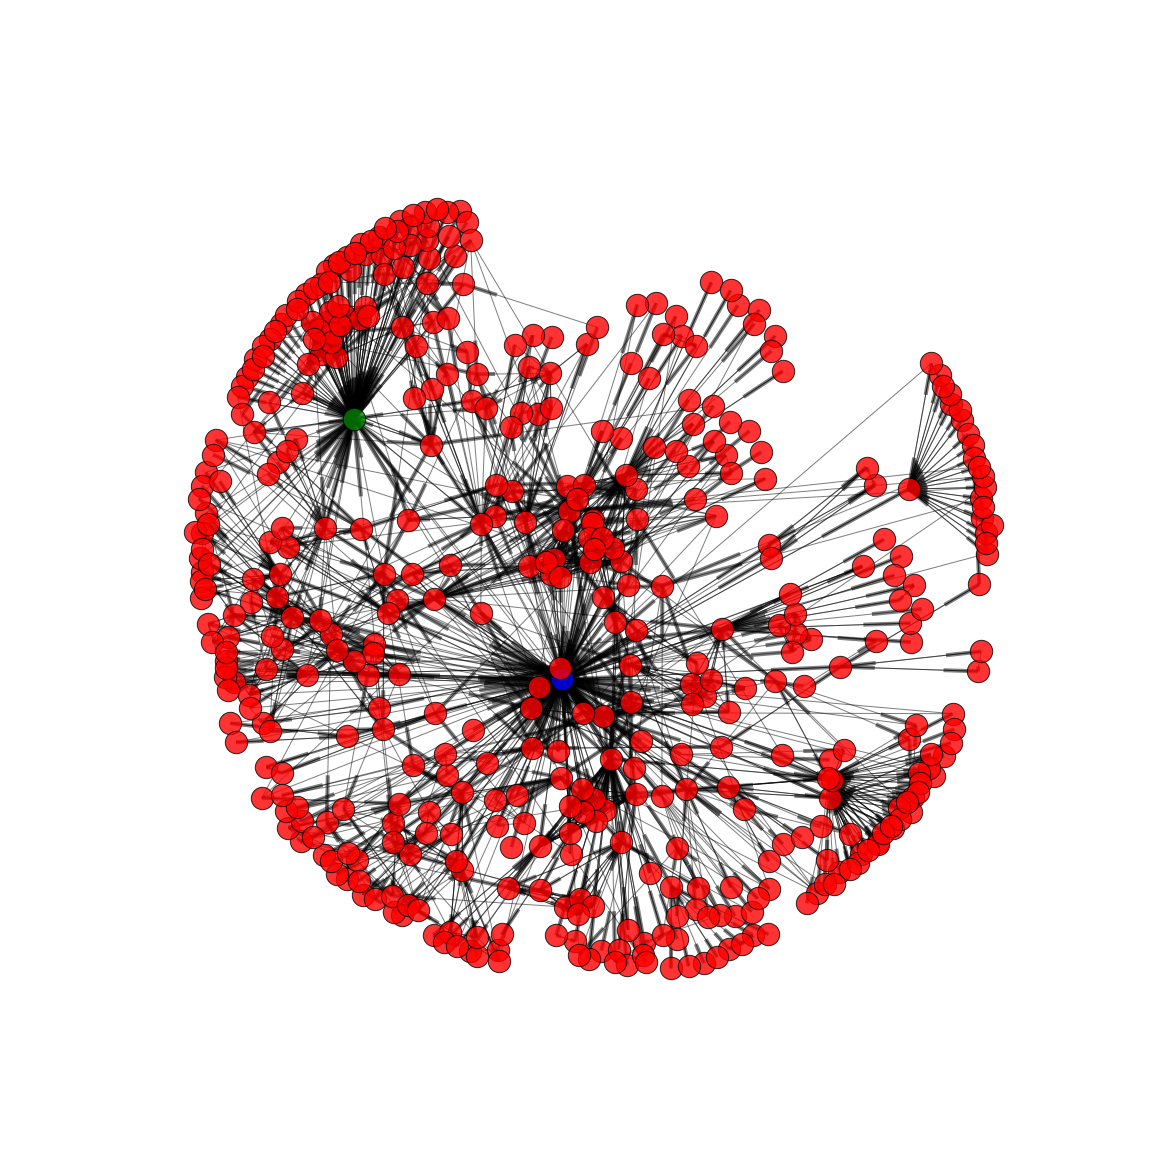

In [46]:
pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[45],#fibonacci
                       node_color='b',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[108],#fibonacci
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=set(graph.keys())-set([45, 108]),
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
plt.axis('off')
plt.show() # display

## Catalan

In [217]:
graph = oeis_graph(seq_id=108, depth=3)


cross references of sequence id 108:
{69640, 2057, 94216, 68875, 176137, 142, 119822, 33552, 99731, 14486, 59288, 22553, 211611, 30237, 33184, 1699, 98597, 1190, 9766, 24492, 1453, 94638, 39599, 94639, 161581, 60854, 14137, 14138, 32443, 14140, 3517, 957, 3519, 3518, 154559, 106566, 588, 179277, 6480, 81, 8276, 167892, 167893, 984, 344, 48990, 99039, 47072, 137697, 51168, 129763, 130020, 8549, 3046, 32357, 86117, 59365, 1003, 120303, 1392, 120304, 753, 121839, 2420, 245, 736, 124926, 1791} 

cross references of sequence id 69640:
{67689, 5249, 74962, 108, 3046} 

cross references of sequence id 67689:
{984, 5249, 60739} 

cross references of sequence id 984:
{182400, 30662, 8459, 261009, 51924, 2457, 59481, 25565, 226078, 158815, 2144, 81696, 152229, 71976, 214377, 108, 258290, 135091, 2420, 98616, 205946, 1405, 226302} 

cross references of sequence id 5249:
{74962, 60739, 515, 69945, 56040, 67689, 163085} 

cross references of sequence id 60739:
{67689, 5249, 1700} 

cross reference

In [218]:
graph.keys()

dict_keys([27907, 4, 5638, 129, 69640, 2057, 68875, 12, 33552, 1303, 30237, 239903, 5408, 290, 244230, 9766, 244231, 71724, 94216, 176137, 197433, 53567, 243264, 243265, 10050, 60739, 106566, 65096, 588, 8275, 8276, 344, 3422, 59365, 48994, 30308, 241765, 40000, 3945, 108, 3517, 255344, 2420, 145598, 67689, 122, 3519, 161227, 166, 60544, 5249, 55746, 142, 262543, 914, 915, 33428, 33184, 1392, 674, 1699, 34886, 1190, 145324, 178, 145596, 145597, 3518, 145599, 145600, 59841, 249026, 35011, 54726, 7623, 84938, 51575, 244232, 74962, 161239, 984, 217, 51675, 99039, 47072, 130020, 108838, 3046, 3047, 1003, 245, 48631])

In [219]:
G=nx.DiGraph()

G.add_nodes_from(graph.keys())

for seq_id, v in graph.items():
    for ref_seq_id in filter(lambda r: r in graph, v['xref_as_set']):
        G.add_edge(seq_id, ref_seq_id)

In [220]:
#G.nodes(), G.edges()

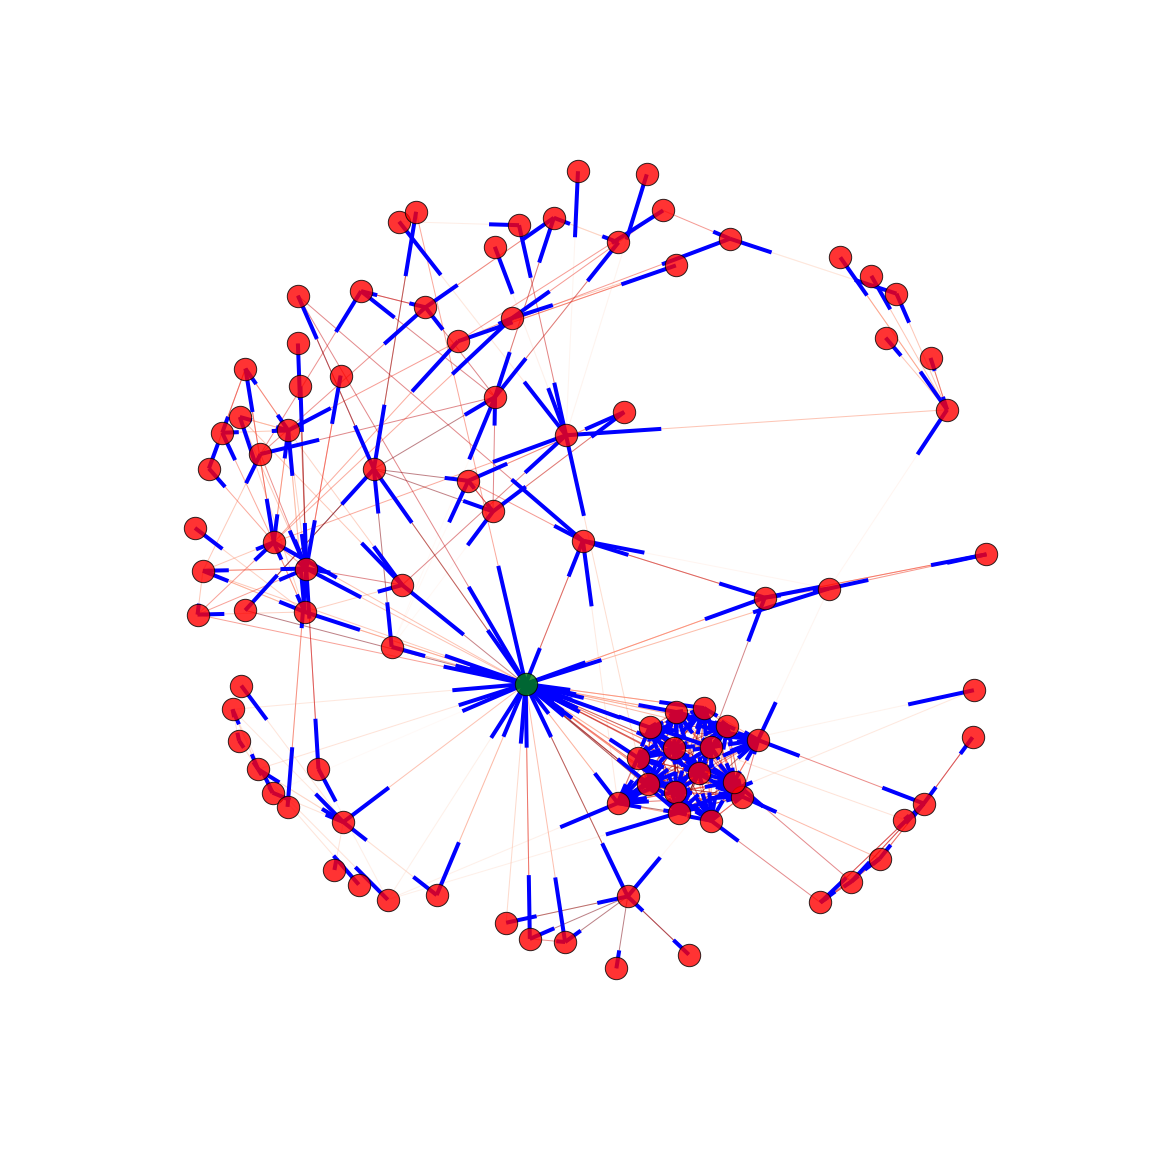

In [240]:
pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[108],#catalan
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=set(graph.keys())-set([45, 108]),
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1,alpha=.5,edge_color=range(len(G.edges())), edge_cmap=plt.cm.Reds)
plt.axis('off')
plt.show() # display

### `networkx` example

The following example is taken from the [official documentation][example].

[example]:https://networkx.github.io/documentation/networkx-1.10/examples/drawing/labels_and_colors.html

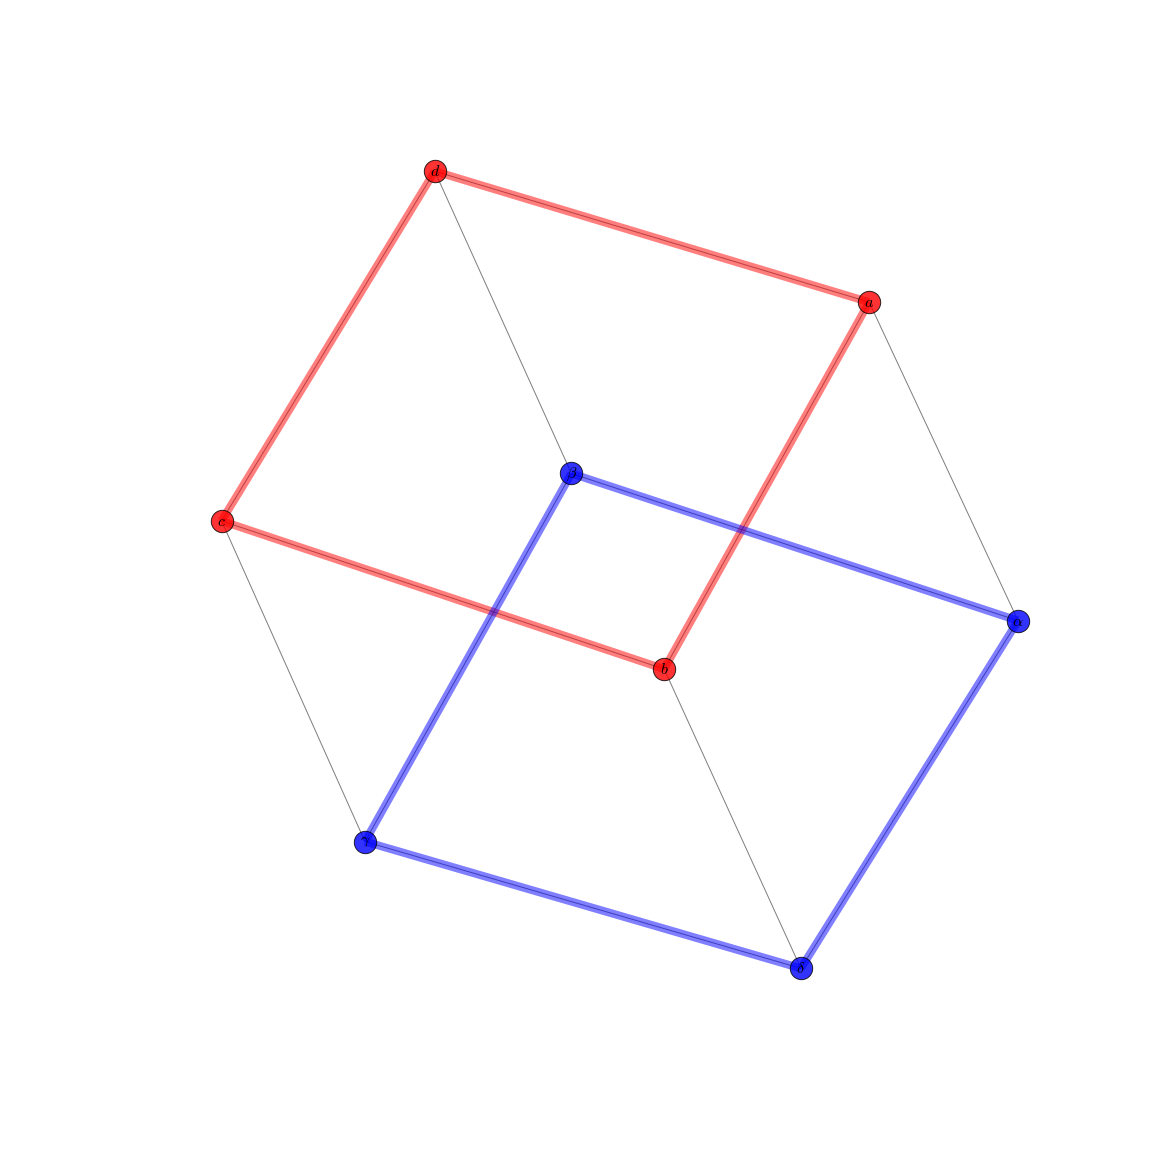

In [3]:

G=nx.cubical_graph()
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist=[(0,1),(1,2),(2,3),(3,0)],
                       width=8,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,
                       edgelist=[(4,5),(5,6),(6,7),(7,4)],
                       width=8,alpha=0.5,edge_color='b')


# some math labels
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
nx.draw_networkx_labels(G,pos,labels,font_size=16)

plt.axis('off')
plt.savefig("labels_and_colors.png") # save as png
plt.show() # display

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.